In [1]:
import serial, struct, time, datetime, os, glob, errno, threading, logging
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
ser = serial.Serial("/dev/tty_rs232", baudrate=9600, stopbits=1, parity="N")

In [4]:
import cv2
camera_port = "/dev/v4l/by-id/usb-046d_Logitech_Webcam_C930e_9BBC0A5E-video-index0"

def set_focus(focus=60, auto=False):
    if auto:
        os.system("v4l2-ctl -d {} -c focus_auto=1".format(camera_port))
    else:
        os.system("v4l2-ctl -d {} -c focus_auto=0".format(camera_port))
        os.system("v4l2-ctl -d {} -c focus_absolute={:d}".format(camera_port, focus))

In [5]:
class UnexpectedDigitException(Exception):
    pass

In [6]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def read_one_measurement(n=16):
    ser.flushInput()
    fmt = "b"*n
    buf_size = struct.calcsize(fmt)
    line = ser.read(buf_size)
    unpacked = struct.unpack(fmt, line)
    return [d & 0b1111 for d in unpacked]

def find_measurement_end():
    for i in range(100):
        m = read_one_measurement(n=1)
        if (m[0]==13):
            return
    raise UnexpectedDigitException()


def process_torque_measurement(raw_measurement):

    unpacked = raw_measurement
    
#     print (("{:2d} "*16).format(*unpacked))
#     print (("{: >8d} "*16).format(*unpacked))
#     print (("{: >8b} "*16).format(*unpacked))
#     print (("{: >8x} "*16).format(*unpacked))

    if unpacked[1] != 4: raise UnexpectedDigitException()
    if unpacked[2] != 1: raise UnexpectedDigitException()
    if unpacked[3] != 8: raise UnexpectedDigitException("check torque sensor is connected")
    units = unpacked[4]
    if not 1 <= units <= 3: raise UnexpectedDigitException("check torque sensor is connected")
    units_dict = {
        1 : "Kg_cm",
        2 : "LB_inch",
        3 : "N_cm"}
    units = units_dict[units]
    polarity = unpacked[5]
    if not polarity in [0, 1]: raise UnexpectedDigitException()
    decimal_point_position = unpacked[6]
    if not decimal_point_position in range(4): raise UnexpectedDigitException()
#     print (decimal_point_position)
    digits = unpacked[7:15]
    digits_s = ("{}"*len(digits)).format(*digits)
    measurement = float(digits_s)
    measurement *= (-1)**polarity
    measurement /= 10**decimal_point_position
    if unpacked[15] != 13: raise UnexpectedDigitException("message got corrupted")
    return measurement, units
    

def process_force_measurement(raw_measurement):

    unpacked = raw_measurement
    
#     print (("{:2d} "*16).format(*unpacked))
#     print (("{: >8d} "*16).format(*unpacked))
#     print (("{: >8b} "*16).format(*unpacked))
#     print (("{: >8x} "*16).format(*unpacked))

    if unpacked[1] != 4: raise UnexpectedDigitException()
    if unpacked[2] != 1: raise UnexpectedDigitException()
    if unpacked[3] != 5: raise UnexpectedDigitException("check force sensor is connected")
    units = unpacked[4]
    if not 5 <= units <= 9: raise UnexpectedDigitException("check force sensor is connected")
    units_dict = {
        5 : "Kg",
        6 : "LB",
        7 : "g",
        8 : "oz",
        9 : "N"
    }
    units = units_dict[units]
    polarity = unpacked[5]
    if not polarity in [0, 1]: raise UnexpectedDigitException()
    decimal_point_position = unpacked[6]
    if not decimal_point_position in range(4): raise UnexpectedDigitException()
#     print (decimal_point_position)
    digits = unpacked[7:15]
    digits_s = ("{}"*len(digits)).format(*digits)
    measurement = float(digits_s)
    measurement *= (-1)**polarity
    measurement /= 10**decimal_point_position    
    if unpacked[15] != 13: raise UnexpectedDigitException("message got corrupted")
    return measurement, units 
    


    

In [7]:
def capture_video(base_file_name, measurement_end_event):
    set_focus(75)
    cap = cv2.VideoCapture(camera_port)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(base_file_name + '_video.avi',fourcc, 20.0, (640,480))
    set_focus(75)
    if not cap.isOpened():
        logging.error("No video is being recorded")
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            frame = cv2.flip(frame,0)

            # write the flipped frame
            out.write(frame)

            cv2.imshow('frame',frame)
            if measurement_end_event.isSet():
                logging.debug("Exiting the video recording loop")
                break
        else:
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [8]:
def aquire_data(name, comment="", video=True):
    set_focus(75)
    try:
        now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        base_dir_name = "data_" + name
        mkdir_p(base_dir_name)
        base_file_name = base_dir_name + "/" + now
        if video:
            measurerement_end_event = threading.Event()
            video_capture = threading.Thread(name="capture_video", 
                                             target=capture_video, 
                                             args=(base_file_name, measurerement_end_event))
            video_capture.start()
            time.sleep(1)
            set_focus(75)

        force_measurements = []
        torque_measurements = []
        t = time.time()
        while True:
            raw_measurement = read_one_measurement()
            t_now = time.time() - t
            try:
                force_measurements.append((*process_force_measurement(raw_measurement), t_now))
            except UnexpectedDigitException:
                try:
                    torque_measurements.append((*process_torque_measurement(raw_measurement), t_now))
                except UnexpectedDigitException:
                    print ("One measurement failed")
                    find_measurement_end()
    except KeyboardInterrupt:
    #     print (force_measurements, torque_measurements)
        if video:
            measurerement_end_event.set()
            video_capture.join()
        force_measurements = np.array(force_measurements)
        torque_measurements = np.array(torque_measurements)
        np.savetxt(base_file_name + "_force.csv", force_measurements, fmt="%s")
        np.savetxt(base_file_name + "_torque.csv", torque_measurements, fmt="%s")
        if comment:
            with open("data_" + name + "/" + now + "_comment", "w") as comment_file:
                comment_file.write(comment)
        print ("Stopped, saved")

In [9]:
aquire_data("Dima", "10.1, unscrewing #4, CRV PH00, set 1, see pictures")

One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
One measurement failed
Stopped, saved


In [10]:
# aquire_data("test")

data_Dima/2017-10-20_20:08:29
10.1, unscrewing #4, CRV PH00, set 1, see pictures


<IPython.core.display.Javascript object>


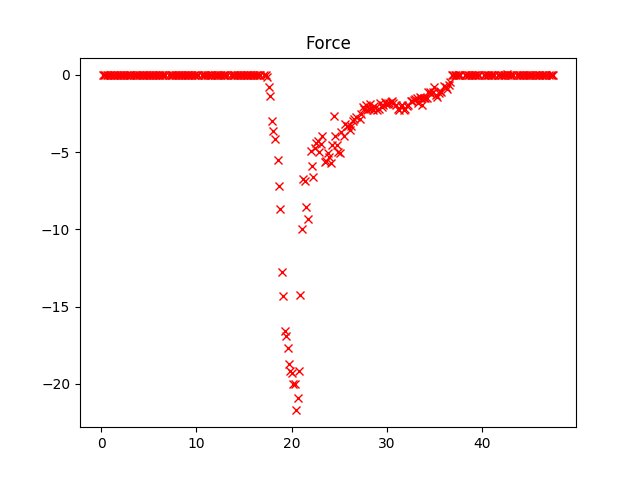

<IPython.core.display.Javascript object>


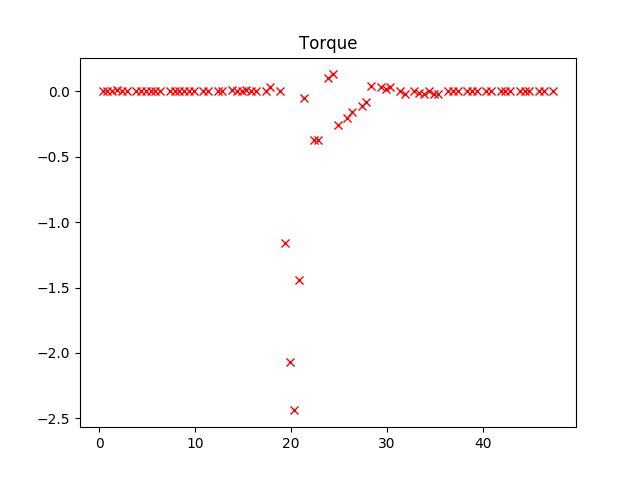

data_Dima/2017-10-20_16:32:18
10.1, second screwing, CRV PH00, set 1, see pictures


<IPython.core.display.Javascript object>


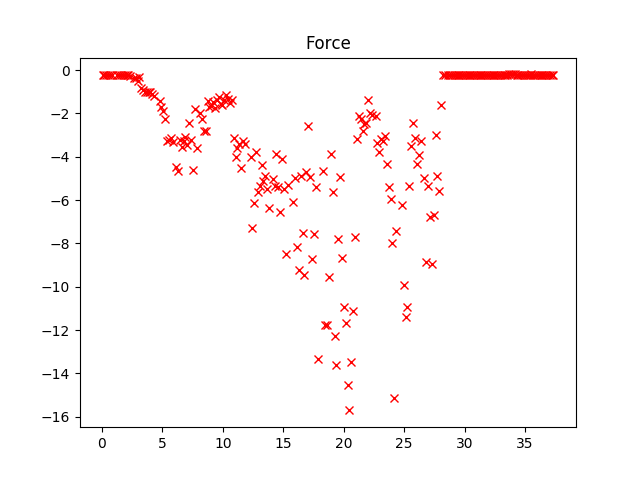

<IPython.core.display.Javascript object>


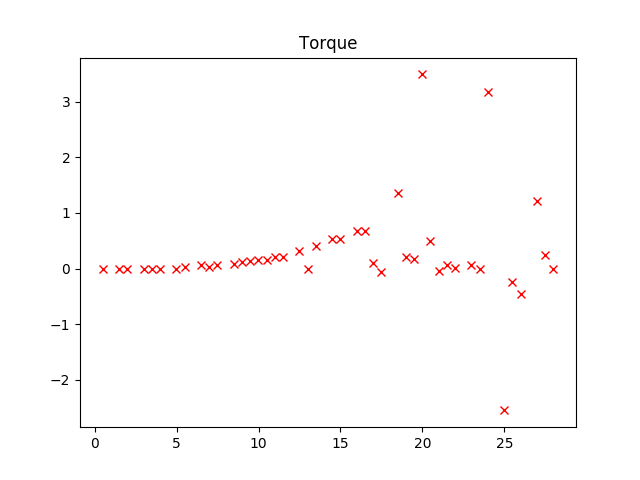

data_Dima/2017-10-20_16:16:20
10.1, first unscrewing, CRV PH00, set 1, see pictures


<IPython.core.display.Javascript object>


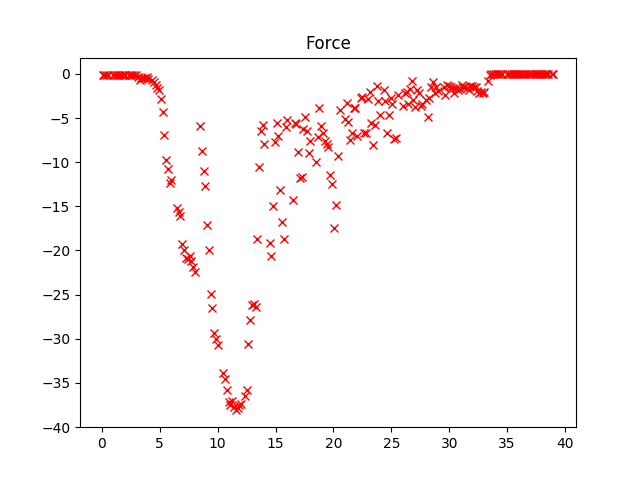

<IPython.core.display.Javascript object>


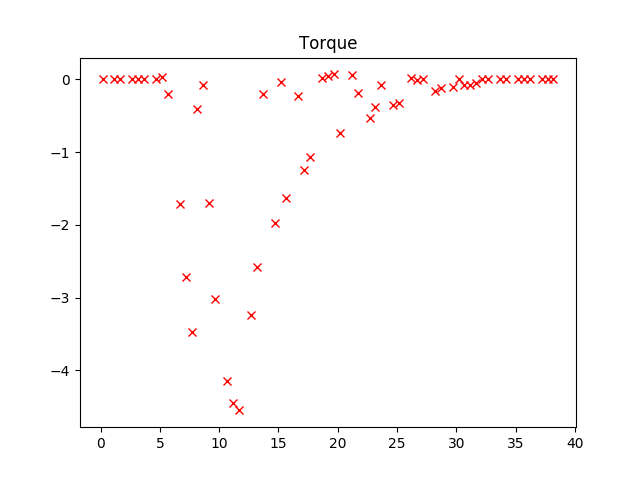

/home/dima/apps/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: loadtxt: Empty input file: "data_Dima/2017-10-20_16:32:50_torque.csv"


data_Dima/2017-10-20_16:32:50
10.1, second unscrewing, CRV PH00, set 1, see pictures
data_Dima/2017-10-20_20:05:05
10.1, screwing #4, CRV PH00, set 1, see pictures


<IPython.core.display.Javascript object>


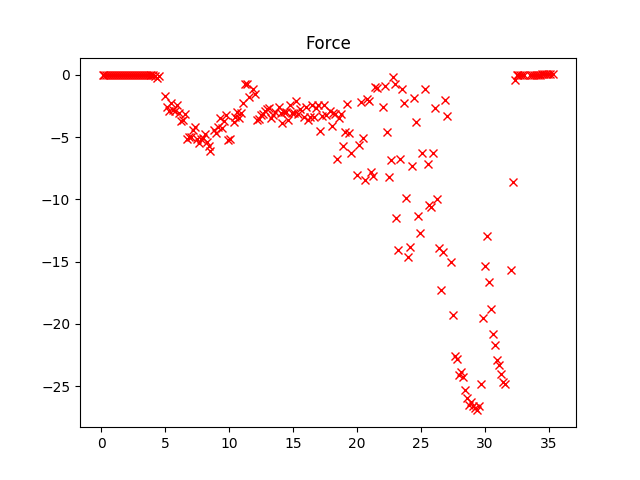

<IPython.core.display.Javascript object>


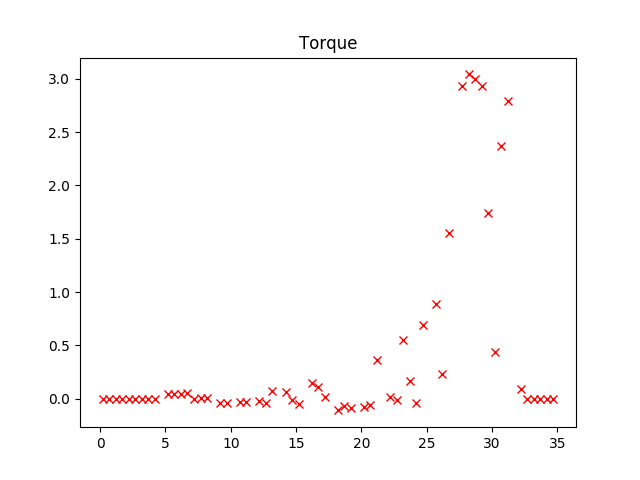

data_Dima/2017-10-20_16:34:03
10.1, third unscrewing, CRV PH00, set 1, see pictures


<IPython.core.display.Javascript object>


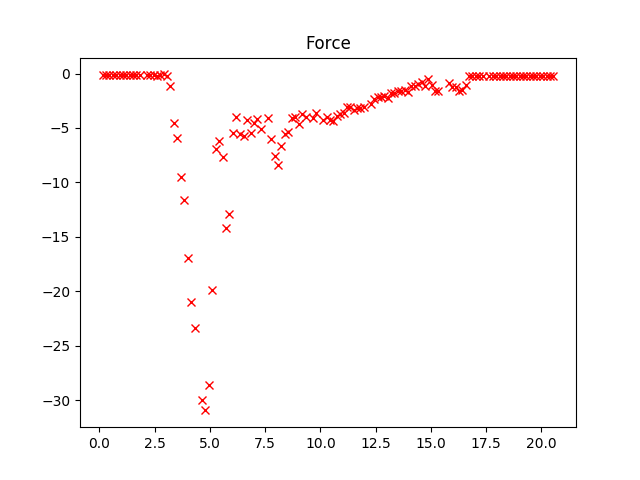

<IPython.core.display.Javascript object>


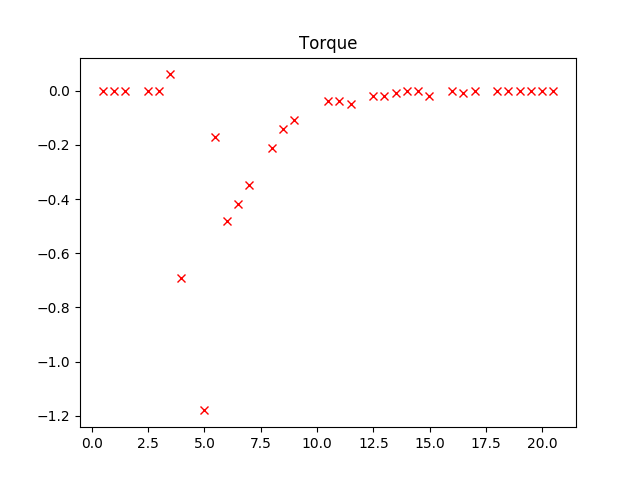

data_Dima/2017-10-20_16:33:37
10.1, third screwing, CRV PH00, set 1, see pictures


<IPython.core.display.Javascript object>


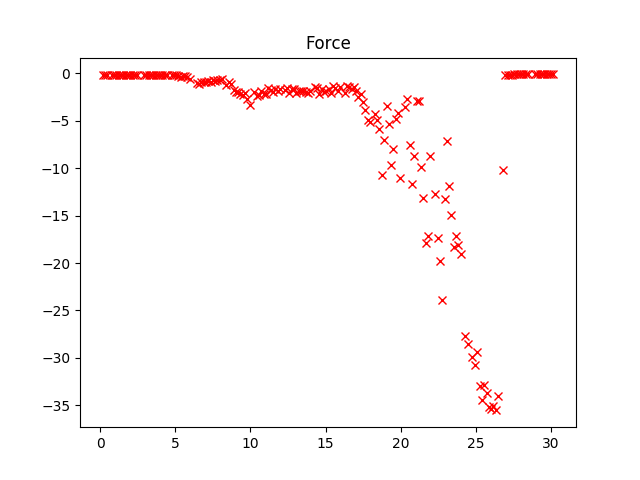

<IPython.core.display.Javascript object>


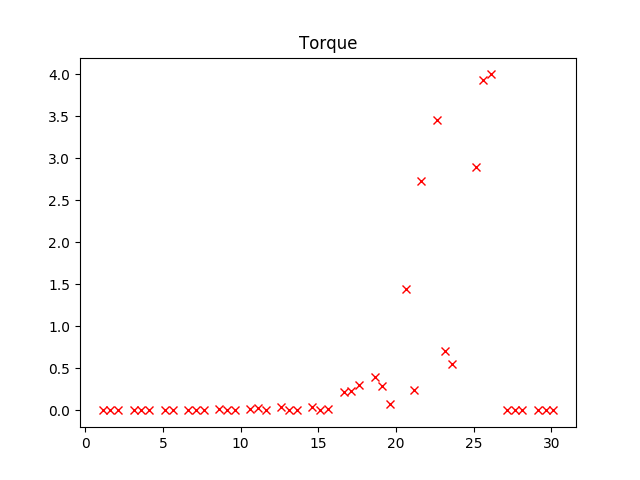

In [11]:
for data_directory in glob.glob("data_*"):
    for force_file in glob.glob(data_directory + "/*_force.csv"):
        print (force_file[:-10])
        torque_file = force_file[:-9] + "torque.csv"
        comment_file = force_file[:-9] + "comment"
        try:
            with open(comment_file) as cf:
                print(cf.read())
        except FileNotFoundError:
            pass
        try:
            force = np.loadtxt(force_file, dtype='S')
            torque = np.loadtxt(torque_file, dtype='S')
            force_f = force.T[0].astype(np.float)
            force_t = force.T[2].astype(np.float)
            assert (force.T[1]==force.T[1,0]).all(), "Some measurements have different units"
            torque_f = torque.T[0].astype(np.float)
            torque_t = torque.T[2].astype(np.float)
            assert (torque.T[1]==torque.T[1,0]).all(), "Some measurements have different units"
            plt.figure()
            plt.title("Force")
            plt.plot(force_t, force_f, 'rx')
            plt.figure()
            plt.title("Torque")
            plt.plot(torque_t, torque_f, 'rx')
        except IndexError:
            logging.warning("Some measurements are empty here!")

In [12]:
threading.enumerate()

[<_MainThread(MainThread, started 140025108248320)>,
 <Thread(Thread-2, started daemon 140024859326208)>,
 <HistorySavingThread(IPythonHistorySavingThread, started 140024825755392)>,
 <Heartbeat(Thread-3, started daemon 140024850933504)>,
 <ParentPollerUnix(Thread-1, started daemon 140024817362688)>]

In [13]:
# Define the codec and create VideoWriter object

set_focus(60)


